Import the libraries

In [3]:
import math
import pandas_datareader as web
import numpy as np
## import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Get the Stock Quote: The price of a stock as quoted on an exchange

In [4]:
df = web.DataReader('SPY', data_source='yahoo', start='2010-01-01', end='2020-11-30') ##end = '2017-12-31', format = 'YYYY-MM-DD'
##Show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,113.389999,111.510002,112.370003,113.330002,118944600.0,91.475693
2010-01-05,113.680000,112.849998,113.260002,113.629997,111579900.0,91.717857
2010-01-06,113.989998,113.430000,113.519997,113.709999,116074400.0,91.782425
2010-01-07,114.330002,113.180000,113.500000,114.190002,131091100.0,92.169884
2010-01-08,114.620003,113.660004,113.889999,114.570000,126402800.0,92.476562
...,...,...,...,...,...,...
2020-11-23,358.820007,354.869995,357.279999,357.459991,63230600.0,357.459991
2020-11-24,363.809998,359.290009,360.209991,363.220001,62415900.0,363.220001
2020-11-25,363.160004,361.480011,363.130005,362.660004,45330900.0,362.660004


Show the number of rows and columns in the data<br>
The data frame has 2004 rows of data and 6 columns

In [5]:
df.shape

(2747, 6)

Visualize the closing price history

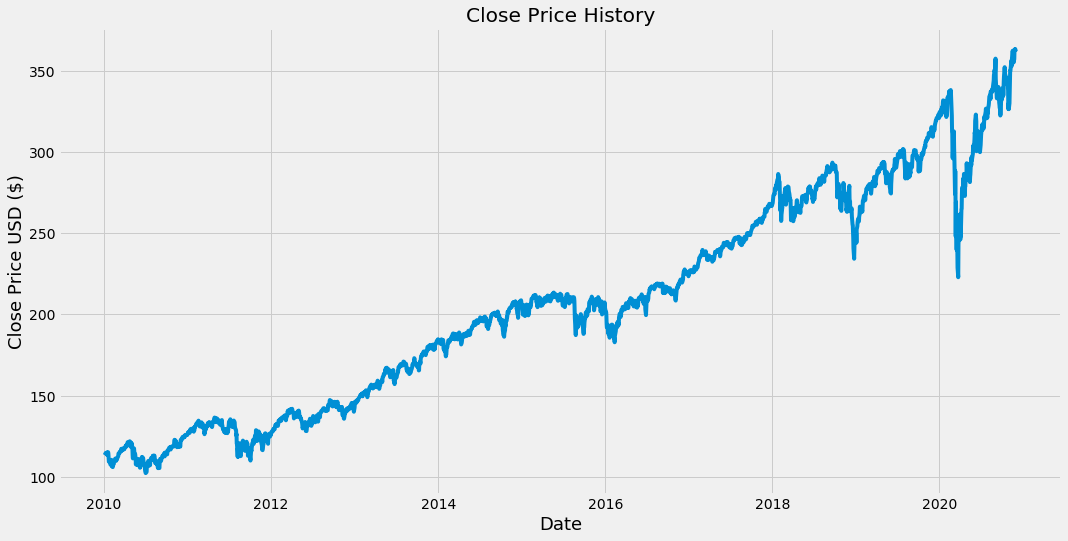

In [6]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

Create a new dataframe with only the 'Close' column

In [7]:
data = df.filter(['Close'])
##Converting the dataframe to a numpy array
dataset = data.values
##Get /Compute the number of rows to train the model on
##That is equivalently the length that we want the training data set to have 
## and equivalently it is equal to the ending index - 1 of the training data set
training_data_len = math.ceil( len(dataset) *.8) ## Length is about 80% of the original data, which is 2003 * .8 = 1603 rounded up

Scale the all of the data to be values between 0 and 1<br>
In practice it is nearly always advantageous to apply pre-processing transformations/ scaling/ normalization to the input data before it is presented to a network. 

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset) ##Compute the minimum and maximum to be used for later scaling to data, then transform it.

Create the training data set<br>
Create the scaled training data set :  a new array containing the scaled values from index 0 to 1602

In [9]:
train_data = scaled_data[0:training_data_len  , : ]
##Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])##The independent training variables or training feature set 'X' (holds the stock price value for the past 60 days at position 'i-60')
    y_train.append(train_data[i,0])##The dependent training variables, or target, or training label set 'Y' (holds the stock price at the 61st day at position 'i-60')
##Convert x_train and y_train to numpy arrays so we can use them for training the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

A LSTM network expects the input to be 3-Dimensional in the form [samples, time steps, features]:<br>
 samples is the number of data points (or rows/ records) we have, <br>
 time steps is the number of time-dependent steps that are there in a single data point (60),<br>
 features/indicators refers to the number of variables we have for the corresponding true value in Y, since we are only using one feature 'Close',<br>
 the number of features/indicators will be one<br>
Reshape the data into the shape accepted by the LSTM

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Build the LSTM network model

In [11]:
model = Sequential()
##First LSTM layer, input_shape = the number of time steps (60 or x_train.shape[1]) while the last parameter is the number of features (1)
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1))) ##Units=number of neurons, return_sequences is set to true since we will add more layers to the model.
model.add(LSTM(units=50, return_sequences=False)) ##LSTM layer with 50 neurons, return sequence by default is False but I put it here just to show
model.add(Dense(units=25)) ##Just your regular densely-connected Neural Network layer with 25 neurons
model.add(Dense(units=1)) ##Just your regular densely-connected Neural Network layer with 1 neuron

Compile the model<br>
 optimizer = adam and the optimizer is used to improve upon the loss<br>
 loss function = mean_squared_error (MSE) and loss functions are used to measure how well the model did on training

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

Fit / Train the model<br>
Batch Size: Total number of training examples present in a single batch<br>
Epoch:The number of iterations when an ENTIRE dataset is passed forward and backward through the neural network .<br>
Fit: Another word for train

In [13]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
2138/2138 [==============================] - 248s 116ms/step - loss: 7.4570e-04


Create the testing data set<br>
Create the scaled testing data set : a new array containing the scaled values from index 1543 to 2002 of the dataframe, for a total length of 460, using the past 60 days

In [14]:
test_data = scaled_data[training_data_len - 60: , : ]
##Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] ##Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])##The independent testing variables or testing feature set 'X' (holds the stock price value for the past 60 days at position 'i-60')
##Convert x_test to a numpy array so we can use it to test and make predictions using the LSTM model we created
x_test = np.array(x_test)

A LSTM network expects the input to be 3-Dimensional in the form [samples, time steps, features]:<br>
 samples is the number of data points (or rows/ records) we have, <br>
 time steps is the number of time-dependent steps that are there in a single data point (60),<br>
 features/indicators refers to the number of variables we have for the corresponding true value in Y, since we are only using one feature 'Close',<br>
 the number of features/indicators will be one<br>
Reshape the data into the shape accepted by the LSTM

In [15]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) ##Reshaping the variable to be 3-Dimensional in the form [samples, time steps, features] for the Neural Network

Getting the models predicted price values

In [16]:
predictions = model.predict(x_test) ##Getting the models predicted price values
predictions = scaler.inverse_transform(predictions) ##Undo the scaling

Get the root mean squared error (rmse)<br>
RMSE is a good measure of how accurately the model predicts the response<br>
(RMSE) is the standard deviation of the residuals (prediction errors).<br>
Lower values of RMSE indicate better fit. <br>
Usually you want to evaluate your model with other metrics as well to truly get an idea of how well your model performs.

Calculate/Get the value of RMSE

In [17]:
rmse=np.sqrt(np.mean((predictions- y_test)**2))
rmse

7.757266268078628

Plot the data

In [35]:
train = data[:training_data_len] 
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\hasse\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Visualize the data

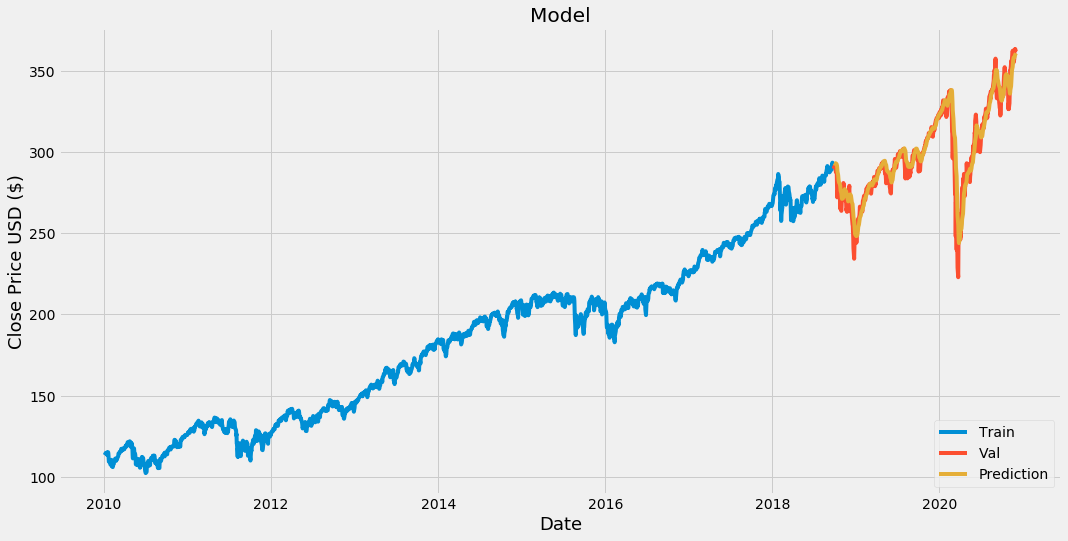

In [36]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Prediction' ], loc='lower right')
plt.show()

Show the valid/actual/close prices and predicted prices

In [37]:
valid

,Close,Predictions
Date,,
2018-09-26,289.880005,293.225433
2018-09-27,290.690002,293.156555
2018-09-28,290.720001,293.084381
2018-10-01,291.730011,293.014923
2018-10-02,291.559998,293.053558
...,...,...
2020-11-23,357.459991,358.519379
2020-11-24,363.220001,358.669586
2020-11-25,362.660004,359.339935


Get the quote from '2010-01-01' to '2020-11-30' to predict the closing price for '2020-12-1'

In [38]:
spy_quote = web.DataReader('SPY', data_source='yahoo', start='2010-01-01', end='2019-11-30') 

Create a new dataframe with only the 'Close' column

In [39]:
new_df = spy_quote.filter(['Close']) 
##Get the last 60 rows of data from the stock/ aka get the past 60 days of the stock and convert it to an array and store it in a variable
last_60_days = new_df[-60:].values 

Transform the data to values between 0 and 1

In [40]:
last_60_days_scaled  = scaler.transform(last_60_days) 

Create an empty list

In [41]:
X_test = [] 
##Append the data (the past 60 values to predict the 61st value)
X_test.append(last_60_days_scaled) 
##Convert X_test to a numpy array so we can use it to test and make predictions using the LSTM model we created
X_test = np.array(X_test) 
##Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

Get the predicted scaled price

In [42]:
pred_price = model.predict(X_test) 
##Undo the scaling
pred_price = scaler.inverse_transform(pred_price) 
print(pred_price)##Print the predicted price

[[314.83887]]


Get the actual closing price for that day<br>
from datetime import datetime

In [43]:
today = '2020-12-01'
##today = datetime.today().strftime('%Y-%m-%d') ##Get todays date and format it in the form YYYY-MM-DD
todays_price = web.DataReader('SPY', data_source='yahoo', start=today, end=today) ##Get the stock price for today
print(todays_price['Close']) ##Print the closing price of the stock for today

Date
2020-12-01    366.019989
Name: Close, dtype: float64


Calculate The Sharp Ratio

In [44]:
R = new_df.cumsum()
r = (R - R.shift(1))/R.shift(1)
r = R.diff()
sr = r.mean()/(r.std() * np.sqrt(252))

In [45]:
print(sr)

Close    0.212541
dtype: float64
